In [83]:

# TimeSeries - Block Maxima
from pydoc import describe
from unicodedata import decimal
from pyextremes import EVA,get_extremes , __version__
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
from scipy.signal import find_peaks
import pdb

In [84]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [85]:
def loadCsv(path):
    loader = pd.read_csv(path, index_col=0,delimiter=',', parse_dates=True).squeeze()
    return loader

In [86]:
# You should first clean the data, removing the NaN values or columns of no interest for the analysis.
# Thus use the final data-file to perform the analysis as csv file.

#Important variables to Set up, before running the code-Self explanatory
FILE = 'joao_data.csv'
PERCENTILE= '25%'
DEPENDENT='Produzida'
EXTREME_TYPE= 'low'
TIME_START ='13:00:00'
TIME_END ='16:00:00'
#you could also try BLOCK_MAXIMA, but it has not been tested - so proceed with caution
EVA_METHOD ='POT' 

dataOriginal = loadCsv(FILE)
# print(data.head())
# print(data.describe())
print(dataOriginal.info())
# data.dropna(inplace=True)
print(dataOriginal.info())
print(dataOriginal.head())


<class 'pandas.core.frame.DataFrame'>
Index: 21908 entries, 0 to 21907
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   datetime            21908 non-null  object 
 1   Humidity            21908 non-null  float64
 2   Temperature         21908 non-null  float64
 3   cloudcover          21908 non-null  float64
 4   windspeedKmph       21908 non-null  float64
 5   Solar w/m2          21908 non-null  float64
 6   Diffuse Solar w/m2  21908 non-null  float64
 7   Produzida           21908 non-null  float64
 8   year                21908 non-null  int64  
 9   month               21908 non-null  int64  
 10  day                 21908 non-null  int64  
 11  timestamp           21908 non-null  object 
dtypes: float64(7), int64(3), object(2)
memory usage: 2.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 21908 entries, 0 to 21907
Data columns (total 12 columns):
 #   Column              Non-Null Count

<ipython-input-85-e714e80914ab>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  loader = pd.read_csv(path, index_col=0,delimiter=',', parse_dates=True).squeeze()


In [87]:
print(dataOriginal)

                  datetime  Humidity  Temperature  cloudcover  windspeedKmph  \
0      2018-08-01 02:00:00     82.00        17.00        0.00          17.00   
1      2018-08-01 03:00:00     84.00        17.00        0.00          17.00   
2      2018-08-01 04:00:00     86.00        17.00        1.00          16.00   
3      2018-08-01 05:00:00     87.00        17.00        1.00          15.00   
4      2018-08-01 06:00:00     88.00        17.00        2.00          14.00   
...                    ...       ...          ...         ...            ...   
21903  2021-01-31 19:00:00     89.00        15.00       94.00          19.00   
21904  2021-01-31 20:00:00     90.00        15.00       89.00          19.00   
21905  2021-01-31 21:00:00     91.00        15.00       83.00          18.00   
21906  2021-01-31 22:00:00     91.00        15.00       89.00          19.00   
21907  2021-01-31 23:00:00     90.00        15.00       94.00          19.00   

       Solar w/m2  Diffuse Solar w/m2  

<h1>Engineering</h1>

In [88]:
def filter_by_timeFrame(data, column, start_time, end_time):
    data[column] = pd.to_datetime(data[column])
    data = data[(data[column] >= start_time) & (data[column] <= end_time)]
    return data

data = filter_by_timeFrame(dataOriginal, 'timestamp', TIME_START, TIME_END)


<ipython-input-88-aabf419f9811>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[column] = pd.to_datetime(data[column])


In [89]:
print(data.head())

               datetime  Humidity  Temperature  cloudcover  windspeedKmph  \
11  2018-08-01 13:00:00     41.00        30.00        0.00          13.00   
12  2018-08-01 14:00:00     40.00        31.00        0.00          15.00   
13  2018-08-01 15:00:00     39.00        32.00        0.00          17.00   
14  2018-08-01 16:00:00     43.00        30.00        0.00          18.00   
35  2018-08-02 13:00:00     26.00        37.00       15.00           6.00   

    Solar w/m2  Diffuse Solar w/m2  Produzida  year  month  day  \
11      890.09              122.33      33.50  2018      8    1   
12      931.07              129.87      35.00  2018      8    1   
13      897.40              133.37      34.00  2018      8    1   
14      799.16              144.52      32.75  2018      8    1   
35      727.93              303.55      29.50  2018      8    2   

             timestamp  
11 2024-10-08 13:00:00  
12 2024-10-08 14:00:00  
13 2024-10-08 15:00:00  
14 2024-10-08 16:00:00  
35 2024-1

In [90]:
# convert Datetime into datetime object and the into index 
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)


<ipython-input-90-45605f7c9ca8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['datetime'] = pd.to_datetime(data['datetime'])


In [91]:
examine =data[DEPENDENT]

In [92]:
print(examine.describe())

count   3652.00
mean      23.81
std       11.51
min        0.25
25%       13.44
50%       28.75
75%       33.75
max       40.00
Name: Produzida, dtype: float64


In [93]:
print(examine)

datetime
2018-08-01 13:00:00   33.50
2018-08-01 14:00:00   35.00
2018-08-01 15:00:00   34.00
2018-08-01 16:00:00   32.75
2018-08-02 13:00:00   29.50
                       ... 
2021-01-30 16:00:00   11.75
2021-01-31 13:00:00    9.25
2021-01-31 14:00:00    7.00
2021-01-31 15:00:00    4.50
2021-01-31 16:00:00    2.75
Name: Produzida, Length: 3652, dtype: float64


In [94]:
model =EVA(examine)

In [95]:
# model.get_extremes(method="BM")
# Check 10% of data 75% of data
                
model.get_extremes(method=EVA_METHOD, threshold=examine.describe()[PERCENTILE], extremes_type=EXTREME_TYPE)

(<Figure size 768x480 with 1 Axes>,
 <Axes: xlabel='datetime', ylabel='Produzida'>)

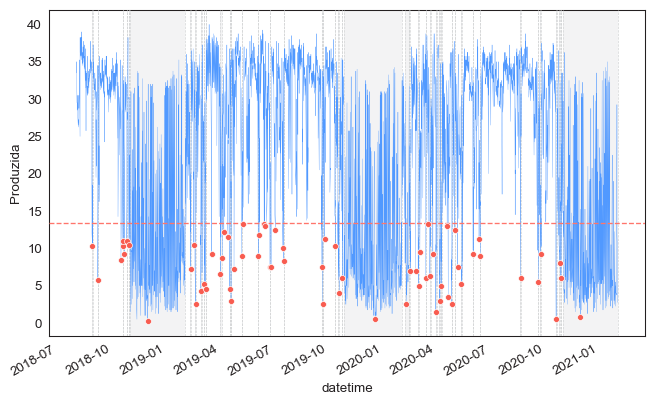

In [96]:
# model.plot_extremes()
model.plot_extremes(show_clusters=True)


In [97]:
# model.fit_model()

# Fit a model to the identified extremes
model.fit_model(distribution="genpareto")  # or "exponential", depending on your data and preference


In [98]:
summary = model.get_summary(
    return_period=[1, 2, 5, 10, 25, 50, 100, 250, 500, 1000],
    alpha=0.95,
    n_samples=1000,
)

In [99]:
pd.set_option('display.float_format', '{:.2f}'.format)

print(summary.head())

               return value  lower ci  upper ci
return period                                  
1.00                   1.05      1.96      0.49
2.00                   0.66      1.34      0.35
5.00                   0.39      0.91      0.18
10.00                  0.28      0.81     -0.06
25.00                  0.20      0.72     -0.23


(<Figure size 768x768 with 4 Axes>,
 (<Axes: title={'center': 'Return value plot'}, xlabel='Return period', ylabel='Produzida'>,
  <Axes: title={'center': 'Probability density plot'}, xlabel='Produzida', ylabel='Probability density'>,
  <Axes: title={'center': 'Q-Q plot'}, xlabel='Theoretical', ylabel='Observed'>,
  <Axes: title={'center': 'P-P plot'}, xlabel='Theoretical', ylabel='Observed'>))

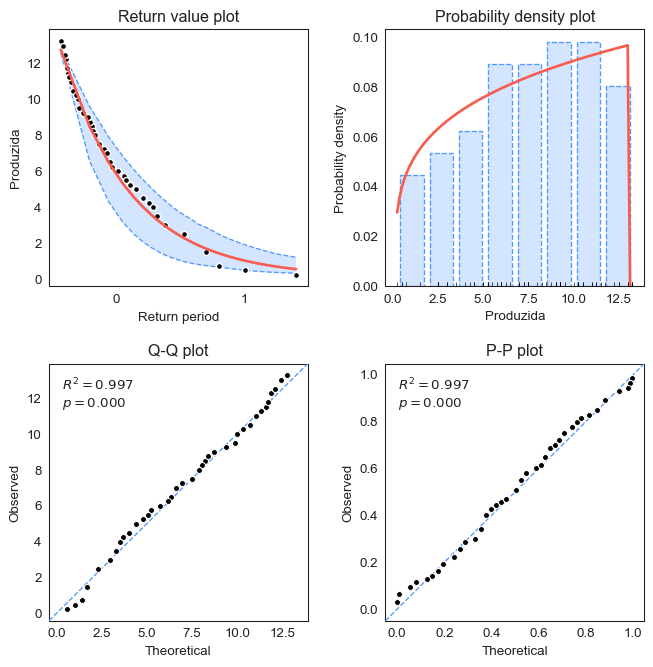

In [100]:
model.plot_diagnostic(alpha=0.95)

In [101]:
extremes = model.extremes

# Getting the indices of the extremes
extreme_indices = extremes.index

# Print or process the indices as needed
# print(extreme_indices)
print(extreme_indices.value_counts())


datetime
2018-08-28 13:00:00    1
2020-03-01 14:00:00    1
2020-03-30 15:00:00    1
2020-03-25 15:00:00    1
2020-03-20 14:00:00    1
                      ..
2019-06-24 13:00:00    1
2019-06-26 13:00:00    1
2019-07-03 13:00:00    1
2019-07-15 16:00:00    1
2020-11-29 15:00:00    1
Name: count, Length: 69, dtype: int64


In [102]:
print(extreme_indices)

DatetimeIndex(['2018-08-28 13:00:00', '2018-09-06 13:00:00',
               '2018-10-15 16:00:00', '2018-10-18 14:00:00',
               '2018-10-19 16:00:00', '2018-10-21 14:00:00',
               '2018-10-25 15:00:00', '2018-10-28 16:00:00',
               '2018-11-29 16:00:00', '2019-02-10 16:00:00',
               '2019-02-15 16:00:00', '2019-02-18 16:00:00',
               '2019-02-27 16:00:00', '2019-03-05 13:00:00',
               '2019-03-07 15:00:00', '2019-03-17 16:00:00',
               '2019-04-01 16:00:00', '2019-04-04 16:00:00',
               '2019-04-07 13:00:00', '2019-04-14 13:00:00',
               '2019-04-17 14:00:00', '2019-04-19 15:00:00',
               '2019-04-24 16:00:00', '2019-05-07 16:00:00',
               '2019-05-09 13:00:00', '2019-06-04 13:00:00',
               '2019-06-06 13:00:00', '2019-06-14 13:00:00',
               '2019-06-15 15:00:00', '2019-06-24 13:00:00',
               '2019-06-26 13:00:00', '2019-07-03 13:00:00',
               '2019-07-

In [103]:
# Creating a DataFrame from DatetimeIndex
dates = pd.to_datetime(extreme_indices)
df = pd.DataFrame(dates, columns=['datetime'])

# Extracting year and time information
df['year'] = df['datetime'].dt.year
df['time'] = df['datetime'].dt.time

# Grouping by year and time and counting the occurrences
grouped_df = df.groupby(['year', 'time']).size().reset_index(name='count')

grouped_df
# here to file csv as well --- <> 


,year,time,count
0,2018,13:00:00,2
1,2018,14:00:00,2
2,2018,15:00:00,1
3,2018,16:00:00,4
4,2019,13:00:00,13
5,2019,14:00:00,2
6,2019,15:00:00,6
7,2019,16:00:00,11
8,2020,13:00:00,3
9,2020,14:00:00,3


In [104]:
grouped_df.to_csv(FILE+'extremes.csv', index=False)

In [105]:
# Grouping by year and counting the total instances per year
year_counts = df.groupby('year').size().reset_index(name='total_per_year')

# Grouping by time and counting the total instances per time
time_counts = df.groupby('time').size().reset_index(name='total_per_time')

# Merging the year and time groupings into one result for display
result_df = pd.concat([year_counts, time_counts], axis=1)
year_counts
time_counts
result_df

,year,total_per_year,time,total_per_time
0,2018.00,9.00,13:00:00,18
1,2019.00,32.00,14:00:00,7
2,2020.00,28.00,15:00:00,14
3,NaN,NaN,16:00:00,30


In [106]:
dataOriginal['datetime'] = pd.to_datetime(dataOriginal['datetime'])
dataOriginal.set_index('datetime', inplace=True)




In [107]:
filterOriginal = dataOriginal.loc[extreme_indices]


In [108]:
filterOriginal.to_csv(FILE+'related2extrems.csv', index=False) 

In [109]:
print(filterOriginal.iloc[:,:-4].describe())

# here we could save the data to a csv file to compare files and extremes <  -- >

       Humidity  Temperature  cloudcover  windspeedKmph  Solar w/m2  \
count     69.00        69.00       69.00          69.00       69.00   
mean      69.06        18.46       58.20          18.20      367.01   
std       11.69         3.06       31.97           8.18      203.71   
min       45.00        12.00        0.00           5.00       65.24   
25%       60.00        16.00       29.00          13.00      244.85   
50%       67.00        18.00       69.00          18.00      323.70   
75%       78.00        21.00       87.00          22.00      451.45   
max       95.00        24.00      100.00          48.00      950.83   

       Diffuse Solar w/m2  Produzida  
count               69.00      69.00  
mean               221.89       7.48  
std                 85.15       3.57  
min                 66.17       0.25  
25%                165.79       5.00  
50%                217.78       7.50  
75%                279.73      10.25  
max                385.87      13.25  


In [110]:
print(data.iloc[:,:-4].describe())

       Humidity  Temperature  cloudcover  windspeedKmph  Solar w/m2  \
count   3652.00      3652.00     3652.00        3652.00     3652.00   
mean      57.73        20.27       27.72          17.73      561.71   
std       13.52         5.34       31.93           7.83      256.57   
min       22.00         7.00        0.00           1.00       64.06   
25%       49.00        16.00        2.00          12.00      345.15   
50%       58.00        19.00       12.00          17.00      563.02   
75%       66.00        24.00       49.00          23.00      793.68   
max       96.00        40.00      100.00          51.00     1037.09   

       Diffuse Solar w/m2  Produzida  
count             3652.00    3652.00  
mean               171.48      23.81  
std                 84.62      11.51  
min                 62.57       0.25  
25%                113.53      13.44  
50%                138.16      28.75  
75%                213.86      33.75  
max                412.02      40.00  


In [111]:
statsForFiltered= filterOriginal.describe()
statsforNonFiltered = data.describe()

In [112]:
compare = statsForFiltered.iloc[:,:-4]-statsforNonFiltered.iloc[:,:-4]
print(compare)

       Humidity  Temperature  cloudcover  windspeedKmph  Solar w/m2  \
count  -3583.00     -3583.00    -3583.00       -3583.00    -3583.00   
mean      11.32        -1.81       30.48           0.48     -194.70   
min       23.00         5.00        0.00           4.00        1.19   
25%       11.00         0.00       27.00           1.00     -100.30   
50%        9.00        -1.00       57.00           1.00     -239.32   
75%       12.00        -3.00       38.00          -1.00     -342.23   
max       -1.00       -16.00        0.00          -3.00      -86.26   
std       -1.83        -2.28        0.04           0.35      -52.86   

       Diffuse Solar w/m2  Produzida  
count            -3583.00   -3583.00  
mean                50.41     -16.33  
min                  3.59       0.00  
25%                 52.25      -8.44  
50%                 79.61     -21.25  
75%                 65.87     -23.50  
max                -26.15     -26.75  
std                  0.52      -7.94  


<Axes: xlabel='datetime'>

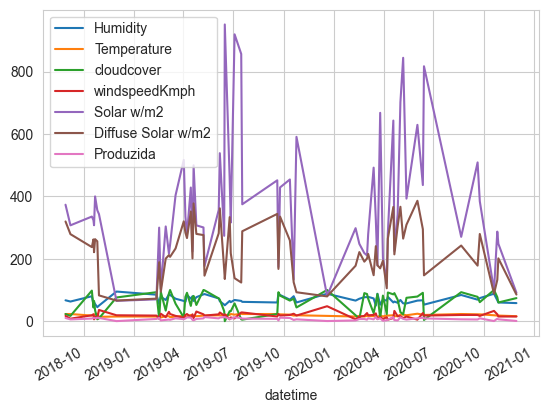

In [113]:
filterOriginal.iloc[:,:-4].plot()

In [114]:
filterOriginal.iloc[:,:-5].corr()

,Humidity,Temperature,cloudcover,windspeedKmph,Solar w/m2,Diffuse Solar w/m2
Humidity,1.00,-0.31,0.67,0.27,-0.49,-0.19
Temperature,-0.31,1.00,-0.36,-0.19,0.48,0.36
cloudcover,0.67,-0.36,1.00,0.25,-0.48,-0.03
windspeedKmph,0.27,-0.19,0.25,1.00,-0.22,-0.31
Solar w/m2,-0.49,0.48,-0.48,-0.22,1.00,0.31
Diffuse Solar w/m2,-0.19,0.36,-0.03,-0.31,0.31,1.00


In [115]:
data.iloc[:,:-5].corr()

,Humidity,Temperature,cloudcover,windspeedKmph,Solar w/m2,Diffuse Solar w/m2
Humidity,1.00,-0.62,0.65,0.11,-0.69,0.16
Temperature,-0.62,1.00,-0.45,-0.03,0.69,0.03
cloudcover,0.65,-0.45,1.00,0.11,-0.59,0.29
windspeedKmph,0.11,-0.03,0.11,1.00,0.11,0.07
Solar w/m2,-0.69,0.69,-0.59,0.11,1.00,-0.02
Diffuse Solar w/m2,0.16,0.03,0.29,0.07,-0.02,1.00


In [116]:
compare2 = filterOriginal.iloc[:,:-5].corr() - data.iloc[:,:-5].corr()



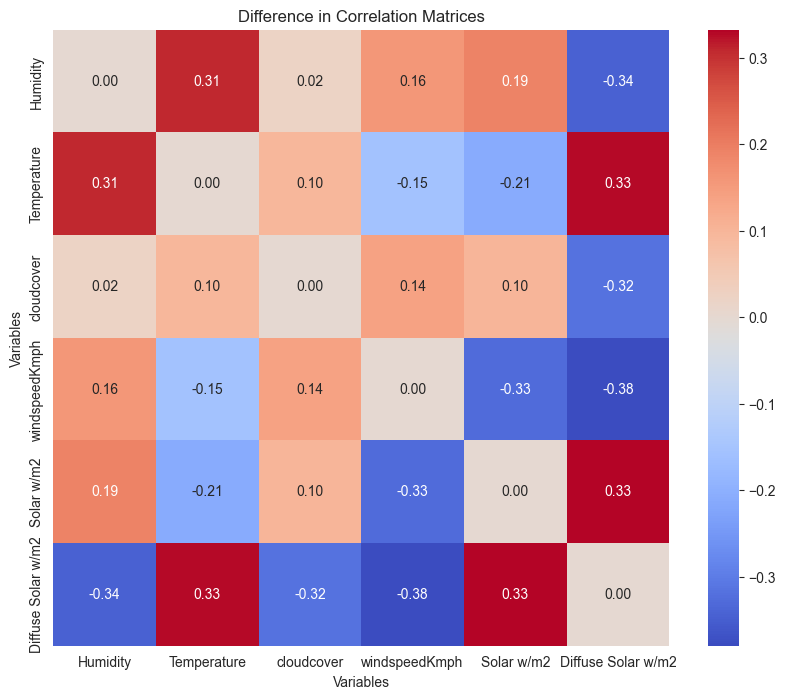

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'compare2' is your DataFrame
# compare2 = filterOriginal.iloc[:,:-5].corr() - data.iloc[:,:-5].corr()

# Set the plot style for aesthetics
sns.set_style("whitegrid")

# Create a figure and an axis
plt.figure(figsize=(10, 8))

# Create the heatmap
sns.heatmap(compare2, annot=True, fmt=".2f", cmap='coolwarm', square=True)

# Add title and labels as necessary
plt.title('Difference in Correlation Matrices')
plt.xlabel('Variables')
plt.ylabel('Variables')

# Show the plot
plt.show()


In [118]:
print(compare2)

                    Humidity  Temperature  cloudcover  windspeedKmph  \
Humidity                0.00         0.31        0.02           0.16   
Temperature             0.31         0.00        0.10          -0.15   
cloudcover              0.02         0.10        0.00           0.14   
windspeedKmph           0.16        -0.15        0.14           0.00   
Solar w/m2              0.19        -0.21        0.10          -0.33   
Diffuse Solar w/m2     -0.34         0.33       -0.32          -0.38   

                    Solar w/m2  Diffuse Solar w/m2  
Humidity                  0.19               -0.34  
Temperature              -0.21                0.33  
cloudcover                0.10               -0.32  
windspeedKmph            -0.33               -0.38  
Solar w/m2                0.00                0.33  
Diffuse Solar w/m2        0.33                0.00  


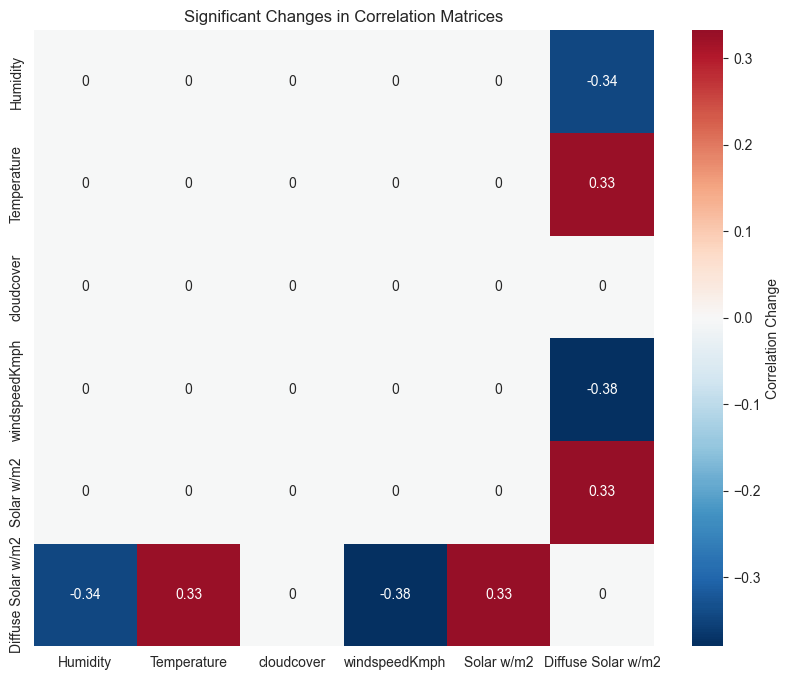

In [119]:

# Assuming compare2 contains the difference in correlation matrices
# Flatten the matrix to get a list of all correlation differences
corr_diff_values = compare2.values.flatten()

NEGATIVE_S =10
POSITIVE_S =90
# Calculate the 90th percentile (for significant positive changes)
P90 = np.percentile(corr_diff_values, POSITIVE_S)
# Calculate the 10th percentile (for significant negative changes)
P10 = np.percentile(corr_diff_values, NEGATIVE_S)

# Create a matrix to store the significant changes
significant_changes = np.where(compare2 > P90, 'Deep Red', np.where(compare2 < P10, 'Deep Blue', 'Not Significant'))

# Optionally, create a heatmap of only significant changes
significant_heatmap_data = np.where(compare2 > P90, compare2, np.where(compare2 < P10, compare2, 0))

# Plot heatmap for significant changes
plt.figure(figsize=(10, 8))
sns.heatmap(significant_heatmap_data, annot=True, cmap='RdBu_r', center=0, cbar_kws={'label': 'Correlation Change'},xticklabels=compare2.index, yticklabels=compare2.index)
plt.title('Significant Changes in Correlation Matrices')
plt.show()